# Wall Street Bets (WSB) sub-reddit post analysis

[Wall Street Bets](https://www.reddit.com/r/wallstreetbets/) according to [Wikipedia](https://en.wikipedia.org/wiki/R/wallstreetbets) is:

 > A subreddit where participants discuss stock and option trading. It has become notable for its profane nature, aggressive trading strategies, and role in the GameStop short squeeze that caused losses on short positions in U.S. firms topping US$70 billion in a few days in early 2021. The subreddit is famous for its colorful jargon and terms.

As mentioned from Wiki, we will examine the short squeeze that occured from around the 12th of Jan 2021 to ~~the 4th of Feb 2021~~ the 18th of March 2021 on Gamestop (NYSE: GME) and AMC Entertainment Holdings (NYSE: AMC). 

For more information see [this Bloomberg article](https://www.bloomberg.com/news/features/2021-02-04/gamestop-gme-how-wallstreetbets-and-robinhood-created-bonkers-stock-market) and [this blog post](https://www.wallstreetbets.shop/blogs/news/dissecting-the-unique-lingo-and-terminology-used-in-the-subreddit-r-wallstreetbets) from the WSB offical merch shop on terms/ emojis used on the sub-reddit.


 

In [62]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("darkgrid")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [63]:
wsb = pd.read_csv('data/reddit_wsb.csv')
wsb.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


In [64]:
wsb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42117 entries, 0 to 42116
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      42117 non-null  object 
 1   score      42117 non-null  int64  
 2   id         42117 non-null  object 
 3   url        42117 non-null  object 
 4   comms_num  42117 non-null  int64  
 5   created    42117 non-null  float64
 6   body       20346 non-null  object 
 7   timestamp  42117 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.6+ MB


The data has 8 columns that represent the following (Taken from [Python Reddit API Wrapper](https://github.com/reddit-archive/reddit/wiki/JSON)):

- title: the title of the link. may contain newlines for some reason

- score: the net-score of the link. note: A submission's score is simply the number of upvotes minus the number of downvotes. If five users like the submission and three users don't it will have a score of 2. Please note that the vote numbers are not "real" numbers, they have been "fuzzed" to prevent spam bots etc. So taking the above example, if five users upvoted the submission, and three users downvote it, the upvote/downvote numbers may say 23 upvotes and 21 downvotes, or 12 upvotes, and 10 downvotes. The points score is correct, but the vote totals are "fuzzed".

- id: this item's identifier, e.g. "8xwlg"

- url: the link of this post. the permalink if this is a self-post

- comms_num: the number of comments that belong to this link. includes removed comments.

- created: the time of creation in local epoch-second format

- body: the raw text. this is the unformatted text which includes the raw markup characters such as ** for bold. <, >, and & are escaped.

- timestamp: datetime about the related activity

Encode timestamp as date and extract date elements.

In [65]:
wsb['timestamp'] = pd.to_datetime(wsb['timestamp'])
wsb['date'] = pd.to_datetime(wsb['timestamp']).dt.date
wsb['date'] = pd.to_datetime(wsb['date'])
wsb['weekday'] = pd.to_datetime(wsb['timestamp']).dt.weekday
wsb['hour'] = pd.to_datetime(wsb['timestamp']).dt.hour

In [66]:
# Sanity check
wsb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42117 entries, 0 to 42116
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   title      42117 non-null  object        
 1   score      42117 non-null  int64         
 2   id         42117 non-null  object        
 3   url        42117 non-null  object        
 4   comms_num  42117 non-null  int64         
 5   created    42117 non-null  float64       
 6   body       20346 non-null  object        
 7   timestamp  42117 non-null  datetime64[ns]
 8   date       42117 non-null  datetime64[ns]
 9   weekday    42117 non-null  int64         
 10  hour       42117 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 3.5+ MB


In [67]:
# Examine missing data
for column in wsb.columns:
    print(f'Column {column}', f'has {100 * sum(wsb[column].isnull())/len(wsb):.2f}% missing data')
    print()

Column title has 0.00% missing data

Column score has 0.00% missing data

Column id has 0.00% missing data

Column url has 0.00% missing data

Column comms_num has 0.00% missing data

Column created has 0.00% missing data

Column body has 51.69% missing data

Column timestamp has 0.00% missing data

Column date has 0.00% missing data

Column weekday has 0.00% missing data

Column hour has 0.00% missing data



From the code above we see that the only column with missing values is the 'body' column with ~48% missing data.

In [68]:
wsb.describe()

,score,comms_num,created,weekday,hour
count,42117.000000,42117.000000,4.211700e+04,42117.000000,42117.000000
mean,1369.820310,199.334354,1.612696e+09,3.525702,6.598903
std,8388.762302,2425.106063,1.146245e+06,1.400882,6.632178
min,0.000000,0.000000,1.601340e+09,0.000000,0.000000
25%,1.000000,2.000000,1.611880e+09,3.000000,1.000000
50%,24.000000,11.000000,1.612255e+09,4.000000,3.000000
75%,163.000000,44.000000,1.612672e+09,4.000000,11.000000
max,348241.000000,93268.000000,1.615995e+09,6.000000,23.000000


Before going any further we will define some of the terms/words/abbreviations that we may see in these posts:
- GME --> The ticker code for Gamestop
- AMC --> Ticker code for AMC Entertainment Holdings
- Robinhood (RH) --> A US brokerage firm offering 'free' trading on ETFs and equities. Millienial focused and is very popular with Gen Y and Z. [See here](https://robinhood.com/us/en/)
- NOK --> Ticker code for Nokia. This stock was also a target of the WSB community

For more info see [this blog post](https://www.wallstreetbets.shop/blogs/news/dissecting-the-unique-lingo-and-terminology-used-in-the-subreddit-r-wallstreetbets).



In [69]:
date_min = wsb['date'].min()
date_max = wsb['date'].max()
print(f'Starting date in data: {date_min}')
print(f'Most recent date in data: {date_max}')

Starting date in data: 2020-09-29 00:00:00
Most recent date in data: 2021-03-17 00:00:00


Remove 2020-09-29 00:00:00 as it its outside the 2021 Gamestop saga

In [70]:
wsb = wsb[wsb['date']!= date_min]

In [71]:
# Sanity check
date_min = wsb['date'].min()
date_max = wsb['date'].max()
print(f'Starting date in data: {date_min}')
print(f'Most recent date in data: {date_max}')

Starting date in data: 2021-01-28 00:00:00
Most recent date in data: 2021-03-17 00:00:00


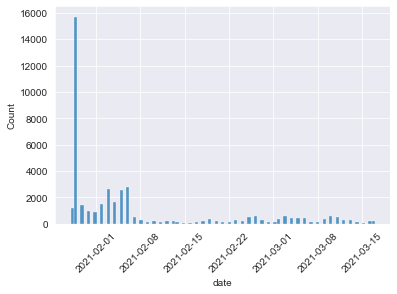

In [72]:
sns.histplot(x='date', data=wsb)
plt.xticks(rotation=45)
plt.show()

A majority of posts occured on or around the 29th of Jan. Lets see what day and time of week the posts were created.

![calender.gif](/images/calender.gif)

[Source](https://tinyurl.com/ygnv9gyk)

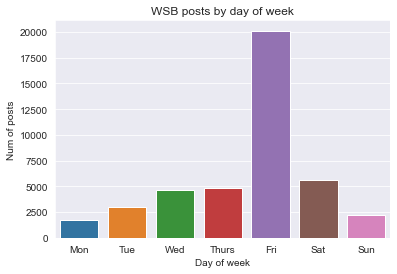

In [73]:
# .index will take 0-6 (days of week), .values (takes number of posts per day of week)
# Eg. .values gives [18818  4642  3282  3247  2009  1737  1375]
sns.barplot(x=wsb['weekday'].value_counts().index, y=wsb['weekday'].value_counts().values)
plt.title('WSB posts by day of week')
plt.ylabel('Num of posts')
plt.xlabel('Day of week')
plt.xticks([0,1,2,3,4,5,6],['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.show()

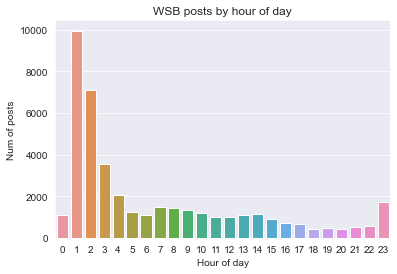

In [74]:
sns.barplot(x=wsb['hour'].value_counts().index, y=wsb['hour'].value_counts().values)
plt.title('WSB posts by hour of day')
plt.ylabel('Num of posts')
plt.xlabel('Hour of day')
plt.show()

Interestingly a majority of posts were posted on a Friday, at the end of a trading week. However looking further into the hour of the posts, posted we see that a majority of posts were posted arounf 1am-3am. (For reference, the timezone is UTC +8, AKA Pacific Standard Time (PST), which covers most the western US and Canada. Source: https://en.wikipedia.org/wiki/Pacific_Time_Zone)

In [75]:
# Add 'posts' column to sum over posts by date
wsb['post_count'] = 1
by_date = wsb.groupby('date').aggregate({'score': 'mean', 'comms_num': 'mean', 'post_count': 'sum'}).reset_index()
# Change date to string for plotting purposes
by_date['date'] = by_date['date'].astype('string')
# Sanity check
by_date.head()

,date,score,comms_num,post_count
0,2021-01-28,960.609023,142.193818,1197
1,2021-01-29,408.457309,52.371288,15694
2,2021-01-30,4618.594101,515.766152,1424
3,2021-01-31,5230.513312,306.713525,939
4,2021-02-01,4230.302036,531.211538,884


[]

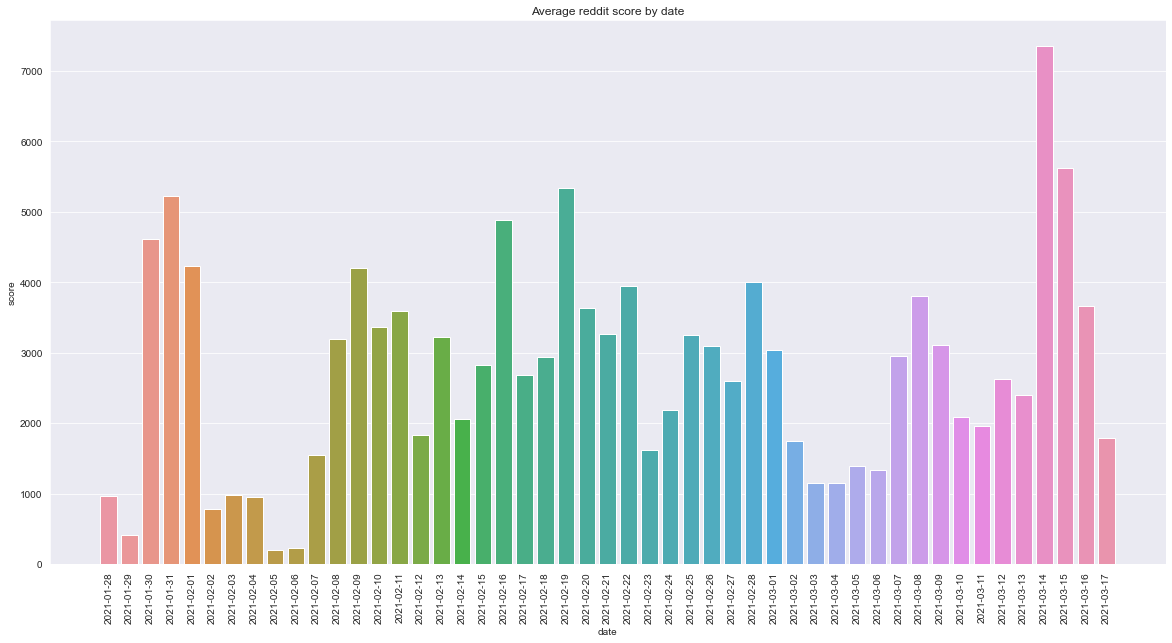

In [76]:
plt.figure(figsize=(20,10))
sns.barplot(x='date', y='score', data=by_date)
plt.xticks(rotation=90)
plt.title('Average reddit score by date')
plt.plot()

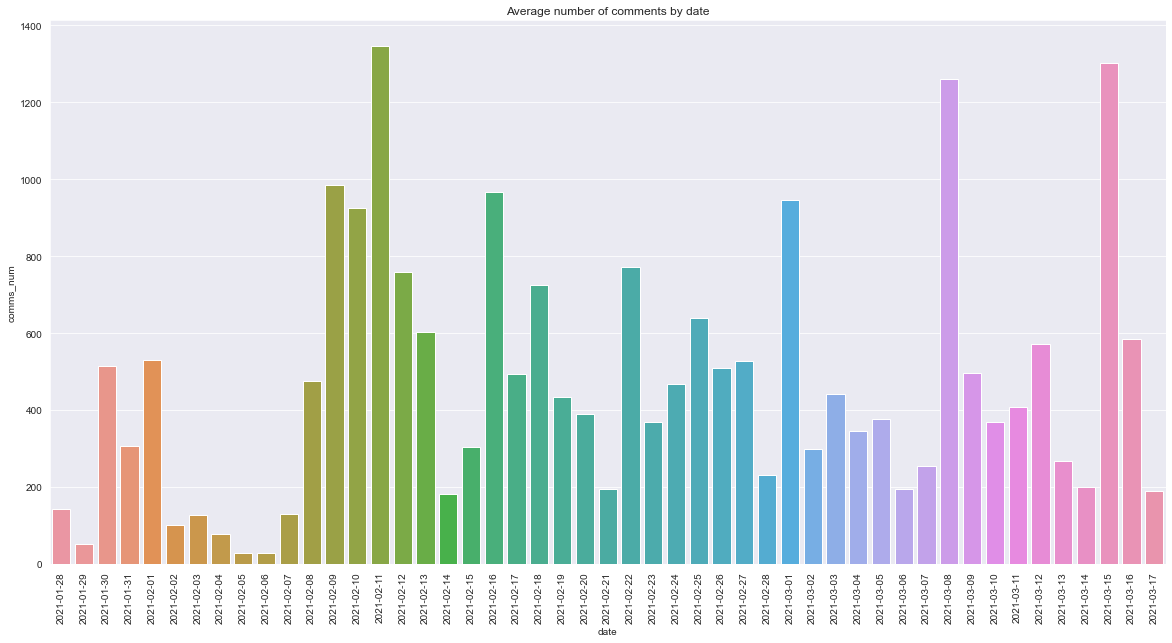

In [77]:
plt.figure(figsize=(20,10))
sns.barplot(x='date', y='comms_num', data=by_date)
plt.xticks(rotation=90)
plt.title('Average number of comments by date')
plt.show()

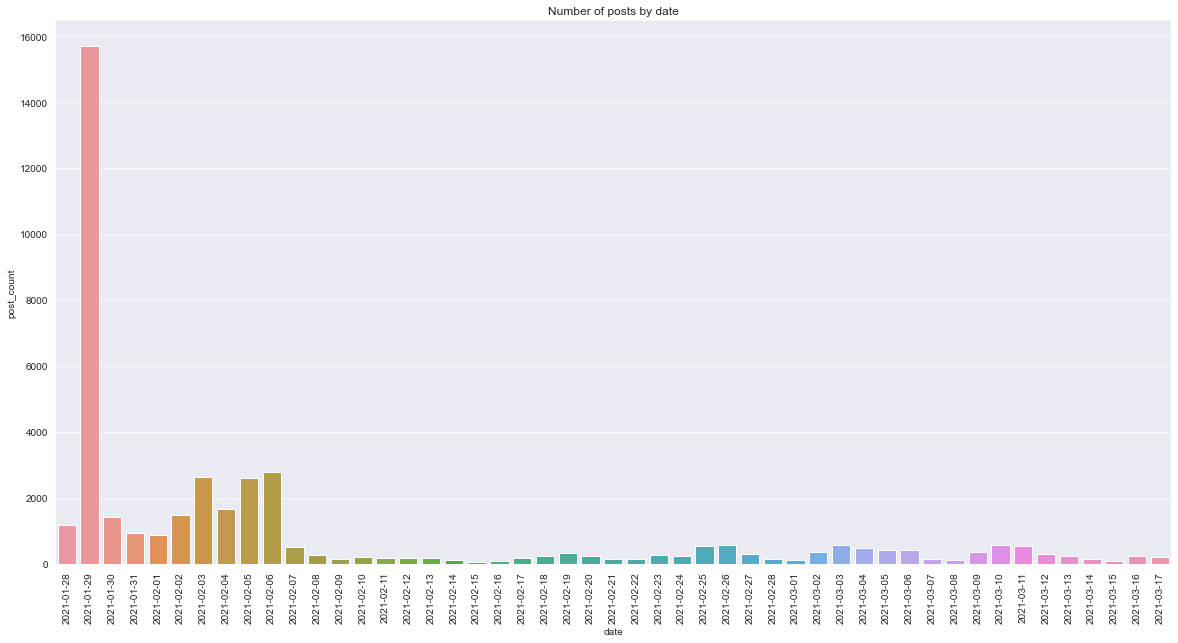

In [78]:
plt.figure(figsize=(20,10))
sns.barplot(x='date', y='post_count', data=by_date)
plt.xticks(rotation=90)
plt.title('Number of posts by date')
plt.show()

## Zooming in on key dates

In [81]:
hype1 = wsb[(wsb['date']>='2021-1-29')& (wsb['date']<='2021-2-2')]
# Change date to string for plotting purposes
hype1['date'] = hype1['date'].astype('string')

<ipython-input-81-ad807a92f683>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hype1['date'] = hype1['date'].astype('string')


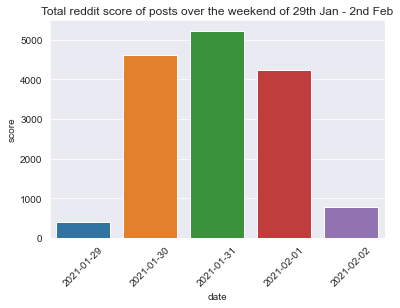

In [87]:
sns.barplot(x='date', y='score', data=hype1, ci=None)
plt.xticks(rotation=45)
plt.title('Total reddit score of posts over the weekend of 29th Jan - 2nd Feb')
plt.show()

In [85]:
hype2 = wsb[wsb['date']<='2021-2-24']
# Change date to string for plotting purposes
hype2['date'] = hype2['date'].astype('string')

<ipython-input-85-1af02cd54a90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hype2['date'] = hype2['date'].astype('string')


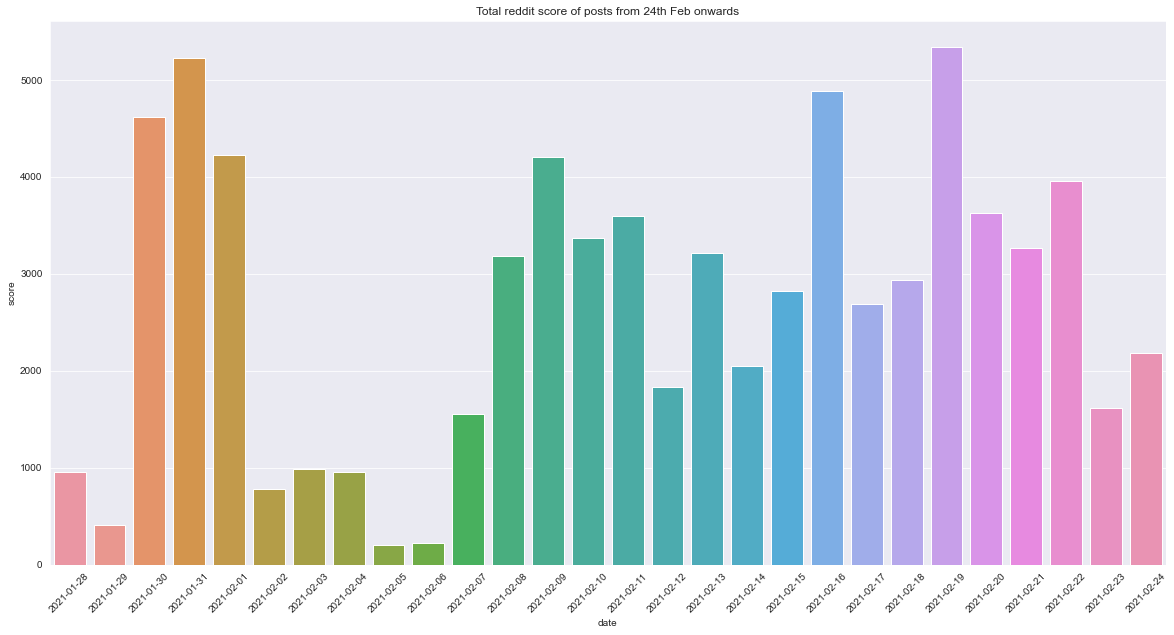

In [89]:
plt.figure(figsize=(20,10))
sns.barplot(x='date', y='score', data=hype2, ci=None)
plt.xticks(rotation=45)
plt.title('Total reddit score of posts from 24th Feb onwards')
plt.show()

From the chart below of the GME stock price (and volume) [sourced from Yahoo Finance](https://tinyurl.com/yzdb6bbe):

1. When GME hit an all time high of $380 USD (closing price) on the 28th of Jan - we see a surge in posts on the 29th of Jan, up to just below 16,000 posts

2. Around the same time above, the number of comments increases to around 500 on the 30th of Jan (Saturday - [Source](https://tinyurl.com/yehvwjv4)), then drops to around 300 comments on the 31st of Jan (Sunday), before rising again to around 500 comments per day on the 1st of Feb (Monday)

3. After a major drop in share price, with a subsequent rise in price from the beginning of March onwards - we see a small rise in post count on a handful of days in March

4. The sum of the score of reddit posts (a mertic of engagement on a post/ posts) incresed after the inital GME runup to $380 USD (29th Jan), then a reasonably steady rise/ increase in scores from the second runup of GME from the 24th Feb onwards.

<img src='images/GME_chart.png'>